In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score, coverage_error, label_ranking_average_precision_score, jaccard_score

In [3]:
df = pd.read_csv('D:/OP/P5/QueryResults_score2.csv')

In [3]:
# load the data associated with programming languages tags
df_prog = pd.read_csv('D:/OP/P5/df_prog.csv')

In [4]:
# load the programming languages tags
df_tags = pd.read_csv('D:/OP/P5/tags_programming_languages.csv')
list_tags = df_tags.Tags.to_list()

In [5]:
stop = stopwords.words('english')
punctuation = string.punctuation

In [6]:
def remove_stopwords_sentence(sentence):
    # print(sentence)
    return pd.Series([word for word in sentence[0].split() if word not in stop])


def remove_stopwords_df(df):
    return df.apply(remove_stopwords_sentence, axis=1)


def stem_sentence(s):
    stemmer = EnglishStemmer()
    return pd.Series([stemmer.stem(w) for w in s if not pd.isna(w)])

In [7]:
body_pipeline = Pipeline(steps=[
    ('remove html tags', FunctionTransformer(pd.DataFrame.replace,
                                             kw_args={'to_replace': '<.*?>', 'value': '', 'regex': True})),
    ('lower', FunctionTransformer(lambda x: x.squeeze(axis=1).str.lower().to_frame())),
    ('remove punctuation', FunctionTransformer(lambda x: x.squeeze(
        axis=1).str.replace('[{}]'.format(punctuation), '').to_frame())),
    ('remove stopwords', FunctionTransformer(remove_stopwords_df, validate=False)),
    ('stemming', FunctionTransformer(pd.DataFrame.apply, kw_args={
     'func': stem_sentence, 'axis': 1}, validate=False)),
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    #('vectorizer', CountVectorizer(lowercase=False,analyzer='word', preprocessor=None, tokenizer=lambda i:i ))
])

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('body', body_pipeline, ['Body'])
    ])

In [9]:
# transform the body with the pipeline
df_body_transform = preprocessor.fit_transform(df)

NameError: name 'df' is not defined

In [12]:
import re


def check_tag(word, list_tags):
    for t in list_tags:
        if word == t:
            simple_t = re.match('(\.?[a-z]+)', t).group()
            return (True, simple_t)
    return (False, '')


def simplify_tags_sentence(s, list_tags):
    l = []
    for w in s.split(' '):
        b, x = check_tag(w, list_tags)
        if b:
            l.append(x)
    return l

In [13]:
# tags
tags_pipeline = Pipeline(steps=[
    ('remove <>', FunctionTransformer(lambda x: x.str.extractall(r'<(.*?)>').groupby(level=0).agg({0: ' '.join}))),
    ('lower', FunctionTransformer(lambda x: x.squeeze(axis=1).str.lower().to_frame())),
    ('select_tags', FunctionTransformer(lambda x: x.squeeze(axis=1).apply(simplify_tags_sentence, list_tags=list_tags).to_frame())),
    #('split', FunctionTransformer(lambda x: x.squeeze(axis=1).str.split(expand=True), validate=False)),
    #('imputer', SimpleImputer(strategy='constant',fill_value=''))
])

In [14]:
# apply the pipeline of transformation for the tags
y_prog = tags_pipeline.fit_transform(df_prog.Tags)

In [15]:
y_prog

,0
0,[angular]
1,"[java, xml]"
2,[asp]
3,[php]
4,[c]
...,...
31675,[kotlin]
31676,"[asp, .net]"
31677,"[ruby, json]"
31678,[.net]


In [16]:
# Use MultiLabelBinarizer to encode the tags
mlb = MultiLabelBinarizer()
y2 = mlb.fit_transform(y_prog[0])

In [58]:
mlb.classes_

array(['.net', 'ada', 'angular', 'applescript', 'asp', 'awk', 'bash',
       'basic', 'batch', 'bc', 'beta', 'boo', 'c', 'clips',
       'coffeescript', 'coldfusion', 'compass', 'coq', 'csh', 'css',
       'curl', 'cython', 'd', 'dart', 'darwin', 'datalog', 'dbase',
       'delphi', 'ecmascript', 'eiffel', 'elixir', 'elm', 'emacs', 'epl',
       'erlang', 'f', 'factor', 'fish', 'flex', 'focus', 'forth',
       'fortran', 'fortress', 'gnu', 'go', 'groovy', 'haskell', 'html',
       'io', 'j', 'java', 'javafx', 'javascript', 'jess', 'jquery',
       'jscript', 'json', 'julia', 'jython', 'jzmq', 'kotlin', 'linq',
       'lisp', 'machine', 'matlab', 'max', 'mysql', 'neko', 'nemerle',
       'newlisp', 'newspeak', 'ocaml', 'occam', 'octave', 'opencl',
       'pascal', 'perl', 'pharo', 'php', 'plesk', 'postscript',
       'powershell', 'processing', 'prolog', 'purescript', 'python', 'q',
       'r', 'ruby', 'scala', 'spark', 'sql', 'verilog', 'vhdl', 'visual',
       'xml'], dtype=object)

In [93]:
y2.shape

(31680, 96)

In [17]:
# transform the title using the pipeline
title_proc = body_pipeline.fit_transform(df_prog.Title.to_frame())

<ipython-input-6-086abaad0bda>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series([word for word in sentence[0].split() if word not in stop])
<ipython-input-6-086abaad0bda>:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series([stemmer.stem(w) for w in s if not pd.isna(w)])


In [68]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, stop_words=[''])
X_tfidf = tfidf_vectorizer.fit_transform(title_proc)

Wall time: 322 ms


In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y2, test_size=0.2, random_state=42)

In [99]:
0 in y2.sum(axis=0)

False

In [97]:
X_tfidf.shape

(31680, 15066)

### Dummy model

In [111]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train,y_train)

DummyClassifier(strategy='most_frequent')

In [112]:
pred_dummy = dummy_clf.predict(X_test)

In [113]:
precision_score(y_test,pred_dummy, average='micro')

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [74]:
recall_score(y_test,pred_dummy, average='micro')

0.0

In [76]:
f1_score(y_test,pred_dummy, average='micro')

0.0

In [95]:
jaccard_score(y2,pred_dummy, average='samples')

0.0

In [37]:
metrics.coverage_error(y_test,pred_dummy)

4469.0

In [38]:
metrics.label_ranking_average_precision_score(y_test,pred_dummy)

0.2593266450555591

### Decision tree

In [100]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)

DecisionTreeClassifier(random_state=0)

In [101]:
pred_train_dt = clf.predict(X_train)

In [102]:
precision_score(y_train, pred_train_dt, average='micro')

1.0

In [104]:
recall_score(y_train, pred_train_dt, average='micro')

0.9994160394497794

In [106]:
f1_score(y_train, pred_train_dt, average='micro')

0.9997079344475093

In [107]:
pred_test_dt = clf.predict(X_test)

In [108]:
precision_score(y_test, pred_test_dt, average='micro')

0.6170415814587594

In [109]:
recall_score(y_test, pred_test_dt, average='micro')

0.5861934982515218

In [110]:
f1_score(y_test, pred_test_dt, average='micro')

0.601222104144527

In [49]:
metrics.coverage_error(y_test, pred_test_dt)

4253.761944677284

In [50]:
metrics.label_ranking_average_precision_score(y_test,pred_test_dt)

0.22619901682975255

### Cross validation

In [20]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, cross_validate

In [25]:


pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', DecisionTreeClassifier())])

scores_dt = cross_validate(DecisionTreeClassifier(), df_body_transform, y2,
                           scoring={'f1_micro': make_scorer(f1_score, average='micro'), 'recall_micro': make_scorer(recall_score, average='micro'),
                                    'precision_micro': make_scorer(precision_score, average='micro'), 'coverage_error': make_scorer(coverage_error),
                                    'LRAP': make_scorer(label_ranking_average_precision_score)},
                           return_train_score=True,
                           return_estimator=True)

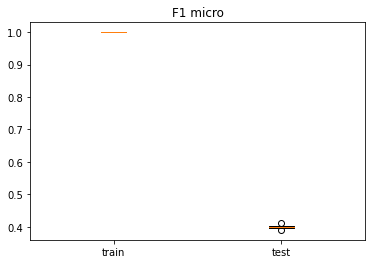

In [27]:
plt.boxplot([scores_dt.get('train_f1_micro'),scores_dt.get('test_f1_micro')], labels=['train','test'])
plt.title('F1 micro')
plt.show()

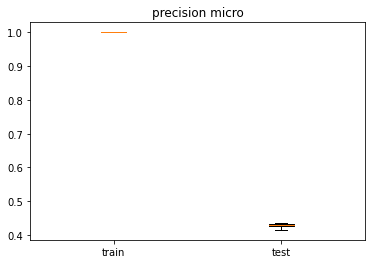

In [28]:
plt.boxplot([scores_dt.get('train_precision_micro'),scores_dt.get('test_precision_micro')], labels=['train','test'])
plt.title('precision micro')
plt.show()

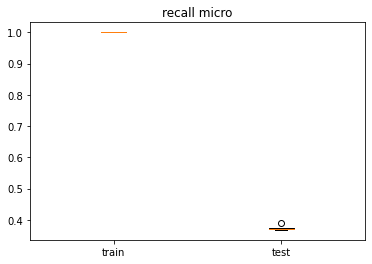

In [29]:
plt.boxplot([scores_dt.get('train_recall_micro'),scores_dt.get('test_recall_micro')], labels=['train','test'])
plt.title('recall micro')
plt.show()

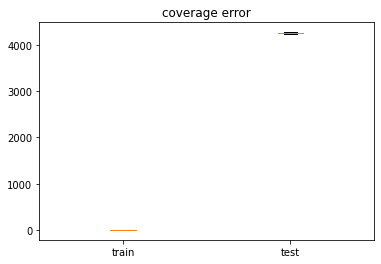

In [30]:
plt.boxplot([scores_dt.get('train_coverage_error'),scores_dt.get('test_coverage_error')], labels=['train','test'])
plt.title('coverage error')
plt.show()

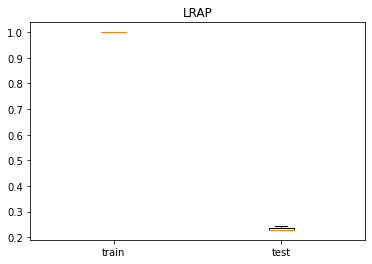

In [31]:
plt.boxplot([scores_dt.get('train_LRAP'),scores_dt.get('test_LRAP')], labels=['train','test'])
plt.title('LRAP')
plt.show()

In [44]:
%%time
scores_title_dt = cross_validate(DecisionTreeClassifier(), X_tfidf, y2,
                                 scoring={'f1_micro': make_scorer(f1_score, average='micro'), 'recall_micro': make_scorer(recall_score, average='micro'),
                                          'precision_micro': make_scorer(precision_score, average='micro'), 'coverage_error': make_scorer(coverage_error),
                                          'LRAP': make_scorer(label_ranking_average_precision_score)},
                                 cv=4,
                                 return_train_score=True,
                                 return_estimator=True,
                                 verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=14.4min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 14.7min remaining:    0.0s


[CV] END .................................................... total time=11.5min
[CV] END .................................................... total time=11.4min
[CV] END .................................................... total time=10.9min
Wall time: 49min 20s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 49.3min finished


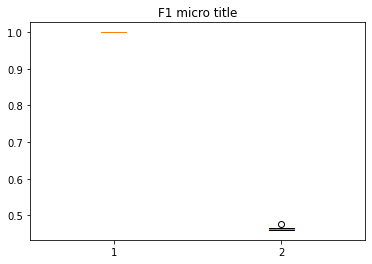

In [45]:
plt.boxplot([scores_title_dt.get('train_f1_micro'),scores_title_dt.get('test_f1_micro')])
plt.title('F1 micro title')
plt.show()

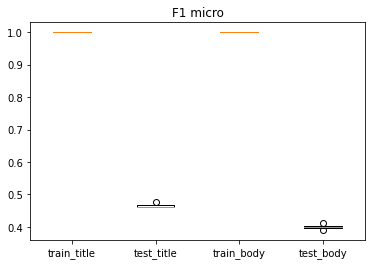

In [46]:
plt.boxplot([scores_title_dt.get('train_f1_micro'),scores_title_dt.get('test_f1_micro'),scores_dt.get('train_f1_micro'),scores_dt.get('test_f1_micro')],
           labels=['train_title','test_title','train_body','test_body'])
plt.title('F1 micro')
plt.show()

In [21]:
scores_dt_title__best_df = pd.DataFrame(scores_title_dt_best)

In [22]:
scores_dt_title__best_df.to_csv('D:/OP/P5/scores_title_dt_best.csv')

In [13]:
%%time
from sklearn.model_selection import GridSearchCV

params_dt = {'max_depth':[10,20], 'min_samples_split':[5,8,10,15]}
grid_dt = GridSearchCV(estimator=DecisionTreeClassifier(),param_grid=params_dt,
                        scoring='f1_micro',cv=4, verbose=1)
grid_dt.fit(X_tfidf, y2)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Wall time: 5h 45min 41s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [10, 20],
                         'min_samples_split': [5, 8, 10, 15]},
             scoring='f1_micro', verbose=1)

In [14]:
grid_dt.best_params_

{'max_depth': 20, 'min_samples_split': 15}

In [15]:
grid_dt.cv_results_

{'mean_fit_time': array([410.84112936, 445.71151358, 382.91583639, 378.46932143,
        729.47120517, 879.75451893, 807.79532987, 733.3245877 ]),
 'std_fit_time': array([23.76073784, 54.96589356,  2.25015826,  4.41123856, 16.94646749,
        99.80865971, 21.31370676, 14.13396237]),
 'mean_score_time': array([25.22214514, 25.43147928, 24.12379616, 23.61234403, 24.30380714,
        34.9320547 , 29.82958388, 24.09240031]),
 'std_score_time': array([1.77184056, 2.26277418, 0.69764633, 0.29044579, 0.56720205,
        3.62597613, 2.09121797, 0.19553214]),
 'param_max_depth': masked_array(data=[10, 10, 10, 10, 20, 20, 20, 20],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[5, 8, 10, 15, 5, 8, 10, 15],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 10, 'min_s

In [18]:
%%time
scores_title_dt_best = cross_validate(DecisionTreeClassifier(max_depth=20, min_samples_split=15), X_tfidf, y2,
                                 scoring={'f1_micro': make_scorer(f1_score, average='micro'), 'recall_micro': make_scorer(recall_score, average='micro'),
                                          'precision_micro': make_scorer(precision_score, average='micro'), 'coverage_error': make_scorer(coverage_error),
                                          'LRAP': make_scorer(label_ranking_average_precision_score)},
                                 cv=4,
                                 return_train_score=True,
                                 return_estimator=True,
                                 verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=12.9min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 16.6min remaining:    0.0s


[CV] END .................................................... total time=13.0min
[CV] END .................................................... total time=13.1min
[CV] END .................................................... total time=56.9min
Wall time: 1h 51min 18s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 111.1min finished


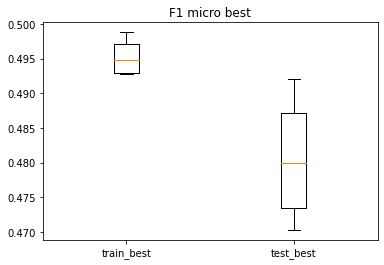

In [20]:
plt.boxplot([scores_title_dt_best.get('train_f1_micro'),scores_title_dt_best.get('test_f1_micro')],
           labels=['train_best','test_best'])
plt.title('F1 micro best')
plt.show()

### RF

In [148]:
X_train_prog, X_test_prog, y_train_prog, y_test_prog = train_test_split(X_tfidf_prog, y2_prog, test_size=0.2, random_state=42)

In [114]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, n_jobs=4)
rf.fit(X_train,y_train)

Wall time: 12.7 s


RandomForestClassifier(n_estimators=10, n_jobs=4)

In [115]:
pred_rf = rf.predict(X_test)

In [116]:
precision_score(y_test, pred_rf, average='micro')

0.8323895809739524

In [117]:
recall_score(y_test, pred_rf, average='micro')

0.4759746146872167

In [118]:
f1_score(y_test, pred_rf, average='micro')

0.605636123928807

In [119]:
jaccard_score(y_test, pred_rf, average='micro')

0.434345822006855

In [120]:
pred_proba = rf.predict_proba(X_test)

In [40]:
pred_proba[0].shape

(6336, 2)

In [41]:
X_test.shape

(6336, 1)

In [42]:
len(pred_proba)

96

array([0, 0, 0, ..., 0, 0, 0])

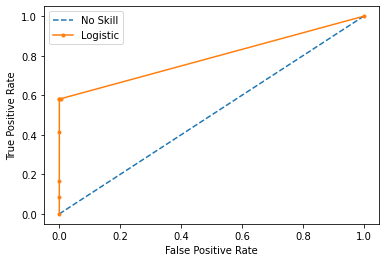

In [121]:
from sklearn.metrics import roc_curve
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test[:,20], pred_proba[1*20][:,1])
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

Best Threshold=0.400000, G-Mean=0.764


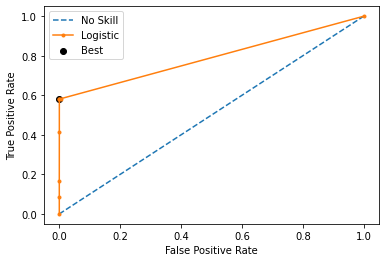

In [126]:
from numpy import sqrt, argmax
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [128]:
pred = pred_proba[:]>0.4

TypeError: '>' not supported between instances of 'list' and 'float'

In [116]:
df_tags = pd.read_csv('D:/OP/P5/tags_programming_languages.csv')

In [129]:
title_proc_prog = title_proc[np.where(y !='')[0]]

In [130]:
title_proc_prog.shape

(31680, 20)

In [131]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, stop_words=[''])
X_tfidf_prog = tfidf_vectorizer.fit_transform(title_proc_prog)

In [132]:
X_tfidf_prog

<31680x15066 sparse matrix of type '<class 'numpy.float64'>'
	with 167718 stored elements in Compressed Sparse Row format>

In [134]:
y2_prog = y2[np.where(y !='')[0]]

In [135]:
y2_prog.shape

(31680, 731)

In [131]:
scores_title_rf = cross_validate(RandomForestClassifier(n_estimators=10, n_jobs=4), X_tfidf, y2,
                                 scoring={'f1_micro': make_scorer(f1_score, average='micro'), 'recall_micro': make_scorer(recall_score, average='micro'),
                                          'precision_micro': make_scorer(precision_score, average='micro'), 'coverage_error': make_scorer(coverage_error),
                                          'jaccard': make_scorer(jaccard_score, average='samples')},
                                 cv=4,
                                 return_train_score=True,
                                 return_estimator=True,
                                 verbose=2)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  17.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.3s remaining:    0.0s


[CV] END .................................................... total time=  18.5s
[CV] END .................................................... total time=  19.4s
[CV] END .................................................... total time=  14.9s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min finished


In [146]:
y2_prog

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

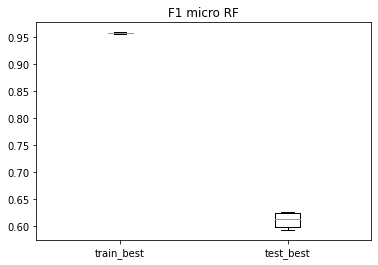

In [130]:
plt.boxplot([scores_title_rf.get('train_f1_micro'),scores_title_rf.get('test_f1_micro')],
           labels=['train_best','test_best'])
plt.title('F1 micro RF')
plt.show()

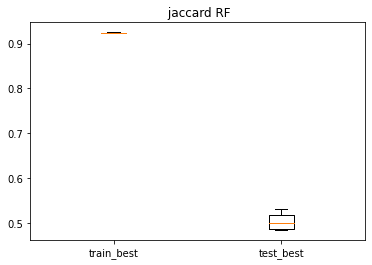

In [133]:
plt.boxplot([scores_title_rf.get('train_jaccard'),scores_title_rf.get('test_jaccard')],
           labels=['train_best','test_best'])
plt.title(' jaccard RF')
plt.show()

### OneVSRest

In [135]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression

In [137]:
lr = LogisticRegression()
ovr_lr = OneVsRestClassifier(lr)
ovr_lr.fit(X_train, y_train)
#y_pred_ovr_lr = ovr_lr.predict(X_test)


D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 11 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 42 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 59 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 68 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 84 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


OneVsRestClassifier(estimator=LogisticRegression())

In [217]:
decision = ovr_lr.decision_function(X_test)

In [218]:
decision2=  (decision == decision.max(axis=1)[:,None]).astype(int)

In [219]:
ovr_lr_jaccard_score = jaccard_score(y_test, decision2, average='samples')

In [220]:
ovr_lr_jaccard_score

0.00014880952380952382

In [104]:
decision2.max()

1

In [221]:
decision_train = ovr_lr.decision_function(X_train)
decision2_train =  (decision_train == decision_train.max(axis=1)[:,None]).astype(int)

In [222]:
jaccard_score(y_train, decision2_train, average='samples')

0.0

In [223]:
pred_train = ovr_lr.predict(X_train)
jaccard_score(y_train, pred_train, average='samples')

0.0

In [225]:
from sklearn.model_selection import StratifiedKFold
scores_ovr_lr = cross_validate(OneVsRestClassifier(lr), X_tfidf, y2,
                                 scoring={'f1_micro': make_scorer(f1_score, average='micro'), 'recall_micro': make_scorer(recall_score, average='micro'),
                                          'precision_micro': make_scorer(precision_score, average='micro'), 'jaccard':make_scorer(jaccard_score,average='samples')},
                                 cv=4,
                                 return_train_score=True,
                                 return_estimator=True,
                                 verbose=2)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 16 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 29 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 42 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 59 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 67 is present in all training examples.
  warnings.warn("Label %s is present in all training example

[CV] END .................................................... total time=   7.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s
D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 13 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 40 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 68 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 69 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 75 is present in all training examples.
  warnings.warn("Label %s is present in all training examples

[CV] END .................................................... total time=   8.0s


D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 33 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 53 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 70 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 84 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg

[CV] END .................................................... total time=   9.0s


D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 11 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 26 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 55 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
D:\Anaconda\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 72 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg

[CV] END .................................................... total time=   7.8s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   37.6s finished


In [227]:
scores_ovr_lr

{'fit_time': array([7.05990338, 7.67552209, 8.68088937, 7.46507645]),
 'score_time': array([0.70561242, 0.3901732 , 0.38647342, 0.43672681]),
 'estimator': [OneVsRestClassifier(estimator=LogisticRegression()),
  OneVsRestClassifier(estimator=LogisticRegression()),
  OneVsRestClassifier(estimator=LogisticRegression()),
  OneVsRestClassifier(estimator=LogisticRegression())],
 'test_f1_micro': array([0., 0., 0., 0.]),
 'train_f1_micro': array([0., 0., 0., 0.]),
 'test_recall_micro': array([0., 0., 0., 0.]),
 'train_recall_micro': array([0., 0., 0., 0.]),
 'test_precision_micro': array([0., 0., 0., 0.]),
 'train_precision_micro': array([0., 0., 0., 0.]),
 'test_jaccard': array([0., 0., 0., 0.]),
 'train_jaccard': array([0., 0., 0., 0.])}

In [226]:
y2.shape

(31680, 96)

### ClassifierChains

In [138]:
# Fit an ensemble of logistic regression classifier chains and take the
# take the average prediction of all the chains.
lr = LogisticRegression()
chains = [ClassifierChain(lr, order='random', random_state=i)
          for i in range(10)]

for chain in chains:
    chain.fit(X_tfidf, y2)

Y_pred_chains = np.array([chain.predict(X_test) for chain in
                          chains])
chain_jaccard_scores = [jaccard_score(y_test, Y_pred_chain >= .5,
                                      average='samples')
                        for Y_pred_chain in Y_pred_chains]

Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_score(y_test,
                                       Y_pred_ensemble >= .5,
                                       average='samples')

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

In [141]:
chain_jaccard_scores

[0.6058633207070707,
 0.6084017255892256,
 0.5961568813131313,
 0.5922506313131313,
 0.607573127104377,
 0.5854114057239058,
 0.6042455808080808,
 0.5768755260942761,
 0.5849247685185185,
 0.6252367424242424]

In [142]:
ensemble_jaccard_score

0.5756655092592592

In [ ]:
from sklearn.svm import SVC

chains_svc = [ClassifierChain(SVC(kernel='poly'), order='random', random_state=i)
          for i in range(10)]

for chain in chains_svc:
    chain.fit(X_tfidf, y2)

Y_pred_chains_svc = np.array([chain.predict(X_test) for chain in
                          chains_svc])
chain_jaccard_scores_svc = [jaccard_score(y_test, Y_pred_chain >= .5,
                                      average='samples')
                        for Y_pred_chain in Y_pred_chains_svc]

Y_pred_ensemble_svc = Y_pred_chains_svc.mean(axis=0)
ensemble_jaccard_score_svc = jaccard_score(y_test,
                                       Y_pred_ensemble_svc >= .5,
                                       average='samples')

In [21]:
chain_jaccard_scores_svc

[0.22889046717171718,
 0.22889046717171718,
 0.05475326178451178,
 0.11946285774410774,
 0.13663983585858586,
 0.05475326178451178,
 0.05475326178451178,
 0.026765046296296294,
 0.11946285774410774,
 0.22889046717171718]

In [25]:
ensemble_jaccard_score_svc

0.0